In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
plt.style.use('classic')
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

In [2]:
n = 100
m = 300
A = np.random.randn(m,n)
b = np.random.randn(m,1)
x_star = np.linalg.lstsq(A, b)[0]
f_star = 0.5 * (np.linalg.norm(A.dot(x_star) - b) ** 2)

In [3]:
N = 300
t = 0.002

In [4]:
x = np.zeros((n,1))
fs = []
gs = []
for i in range(N):
  x = x - t * A.T.dot(A.dot(x) - b)
  fs.append(0.5 * (np.linalg.norm(A.dot(x) - b) ** 2))
  gs.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))

gs_vanilla = gs

In [5]:
x = np.zeros((n,1))
fs = []
gs = []
y = np.copy(x)
for i in range(N):
  x_old = np.copy(x);
  grad = A.T.dot(A.dot(y) - b)
  x = y - t * grad / 2
  y = x + (x - x_old) * (i-2) / (i + 1)
  gs.append(np.linalg.norm(grad))
  if grad.T.dot(x - x_old) > 0:
    x = x_old
    y = x_old

gs_nes = gs

In [6]:
x = np.zeros((n,1))
fs = []
rs = []
xs = []
gs=[]
x_old = g = t = None
k = 20
for i in range(N):
  g_old = g
  g = A.T.dot(A.dot(x) - b)
  if x_old is not None:
    s = x - x_old
    y = g - g_old
    bb_step = s.T.dot(s) / s.T.dot(y)
  else:
    bb_step = 0.002
  t_last = t
  if t is not None:
    t = 0.2 * bb_step + 0.8 * t_last
  else:
    t = bb_step
  x_old = x
  xp = x - t * g
  if i >= k:
      del rs[0]
      del xs[0]
  xs.append(xp)
  rs.append(t * g)
  if i>0:
    F = np.squeeze(np.asarray(rs))
    FtF = F.dot(F.T);
    alpha = np.linalg.solve(FtF, np.ones((FtF.shape[1],1)))
    alpha /= np.sum(alpha)
    x = np.squeeze(np.asarray(xs)).T.dot(alpha)
  else:
    x = xp
  
  fs.append(0.5 * (np.linalg.norm(A.dot(x) - b) ** 2))
  gs.append(np.linalg.norm( A.T.dot(A.dot(x) - b)))

gs_ander = gs

In [7]:
x = np.zeros((n,1))
B = np.identity(n)
gs =[]
for i in range(N):
  grad = A.T.dot(A.dot(x) - b)
  p = np.linalg.solve(B, -grad)
  t = (p.T.dot(A.T.dot(b)) - p.T.dot(A.T.dot(A).dot(x)))/p.T.dot(A.T.dot(A).dot(p))
  s = t * p # should do line search here over t
  x = x + s
  y =  A.T.dot(A.dot(x) - b) - grad
  Bs = B.dot(s)
  B = B + y.dot(y.T) / y.T.dot(s) - Bs.dot(Bs.T) / s.T.dot(Bs)

  gs.append(np.linalg.norm(grad))

gs_bfgs = gs

/usr/local/google/home/bodonoghue/miniconda2/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


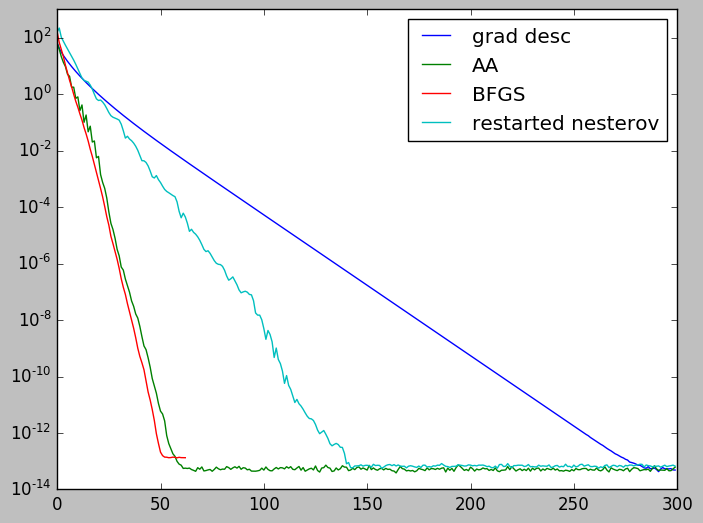

In [8]:
plt.semilogy(gs_vanilla, label='grad desc')
plt.semilogy(gs_ander, label='AA')
plt.semilogy(gs_bfgs, label='BFGS')
plt.semilogy(gs_nes, label='restarted nesterov')
plt.legend()
plt.show()

In [9]:
n = 1000
d = 250
t = 0.2
mu = 0.0
x_n = -0.1 * np.random.rand(d)
x_p = 0.1 * np.random.rand(d)
X_p = 5 * np.random.randn(d, n) + np.tile(x_p, (n, 1)).T
X_n = 5 * np.random.randn(d, n) + np.tile(x_n, (n, 1)).T
X = np.hstack((X_p, -X_n))

def log_reg_grad(y):
    v = np.exp(-np.dot(X.T, y))
    return np.dot(X, 1 / (1 + v) / 2 / n)

def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t * mu, 0)


In [10]:
x = np.zeros((d,1))
gs = []
for i in range(N):
  grad = soft_thresh(log_reg_grad(x), t)
  x = x - t * grad
  gs.append(np.linalg.norm(grad))

gs_vanilla = gs

In [11]:
x = np.zeros((d,1))
fs = []
gs = []
y = np.copy(x)
for i in range(N):
  x_old = np.copy(x);
  grad = soft_thresh(log_reg_grad(y), t)
  x = y - t * grad / 2
  y = x + (x - x_old) * (i-2) / (i + 1)
  gs.append(np.linalg.norm(grad))
  if grad.T.dot(x - x_old) > 0:
    x = x_old
    y = x_old

gs_nes = gs

In [12]:
x = np.zeros((d,1))
fs = []
rs = []
xs = []
gs=[]
x_old = g = None
k = 20
for i in range(N):
  g_old = g
  g = soft_thresh(log_reg_grad(x), t)
  if x_old is not None:
    s = x - x_old
    y = g - g_old
    t = s.T.dot(s) / s.T.dot(y)
  else:
    t = 0.2
  x_old = x
  xp = x - t * g
  if i >= k:
      del rs[0]
      del xs[0]
  xs.append(xp)
  rs.append(t * g)
  if i>0:
    F = np.squeeze(np.asarray(rs))
    FtF = F.dot(F.T);
    alpha = np.linalg.solve(FtF, np.ones((FtF.shape[1],1)))
    alpha /= np.sum(alpha)
    x = np.squeeze(np.asarray(xs)).T.dot(alpha)
  else:
    x = xp
  
  gs.append(np.linalg.norm(g))

gs_ander = gs

In [13]:
x = np.zeros((d,1))
B = np.identity(d)
gs =[]
t = 0.5
for i in range(N):
  grad_old = np.copy(grad)
  grad = soft_thresh(log_reg_grad(x), t)
  p = np.linalg.solve(B, -grad)
  s = t * p  # should do line search here over t
  x = x + s
  y = soft_thresh(log_reg_grad(x), t) - grad
  Bs = B.dot(s)
  B = B + y.dot(y.T) / y.T.dot(s) - Bs.dot(Bs.T) / s.T.dot(Bs)

  gs.append(np.linalg.norm(grad))

gs_bfgs = gs

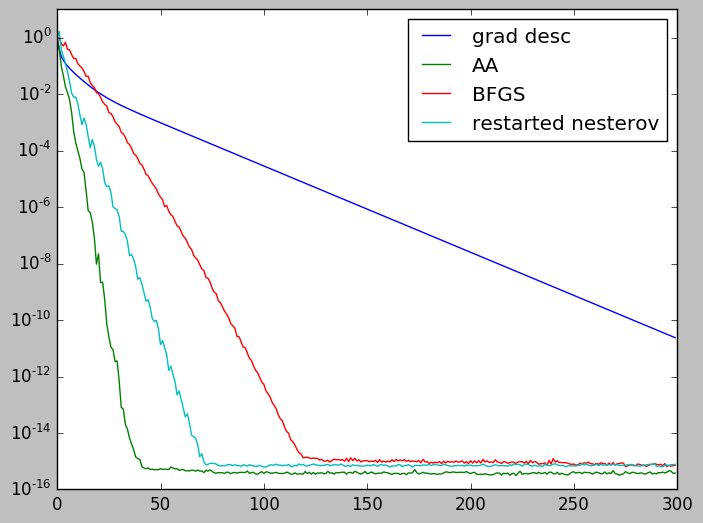

In [14]:
plt.semilogy(gs_vanilla, label='grad desc')
plt.semilogy(gs_ander, label='AA')
plt.semilogy(gs_bfgs, label='BFGS')
plt.semilogy(gs_nes, label='restarted nesterov')
plt.legend()
plt.show()

In [15]:
n = 300
m = 100
mu = 0.1
rho = 0.1
N = 5000

A = np.random.randn(m,n)
b = np.random.randn(m,1)

L = la.cho_factor(A.T.dot(A) + rho * np.identity(n))

def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t, 0)
  
res = []
ds = []
  
z0 = np.linalg.solve(A.T.dot(A), A.T.dot(b))

z = z0
lam = np.zeros((n,1))

for i in range(N):
  z_old = z
  x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
  z = soft_thresh(x - lam, mu / rho)
  lam = lam - x + z
  res.append(np.linalg.norm(x-z))
  ds.append(np.linalg.norm(z - z_old))

r_vanilla = res
d_vanilla = ds


In [16]:
res = []
ds = []

rs = []
xs = []

k = 100
  
z = z0
#z = np.zeros((n,1))

lam = np.zeros((n,1))
for i in range(N):
  z_old = z
  lam_old = lam

  x = la.cho_solve(L, rho * (z + lam) + A.T.dot(b))
  z = soft_thresh(x - lam, mu / rho)
  lam = lam - x + z
  res.append(np.linalg.norm(x-z))
  ds.append(np.linalg.norm(z - z_old))
  
  
  u_old = np.vstack((z_old,lam_old))
  u = np.vstack((z,lam))
  r = u - u_old
  
  xs.append(u)
  rs.append(r)
  if i >= k:
    del rs[0]
    del xs[0]
  if i>0:
    F = np.squeeze(np.asarray(rs))
    FtF = F.dot(F.T);
    alpha = np.linalg.solve(FtF, np.ones((FtF.shape[1],1)))
    alpha /= np.sum(alpha)
    v = np.squeeze(np.asarray(xs)).T.dot(alpha)
  else:
    v = u

  z = v[:n]
  lam = v[n:]

r_aa = res
d_aa = ds

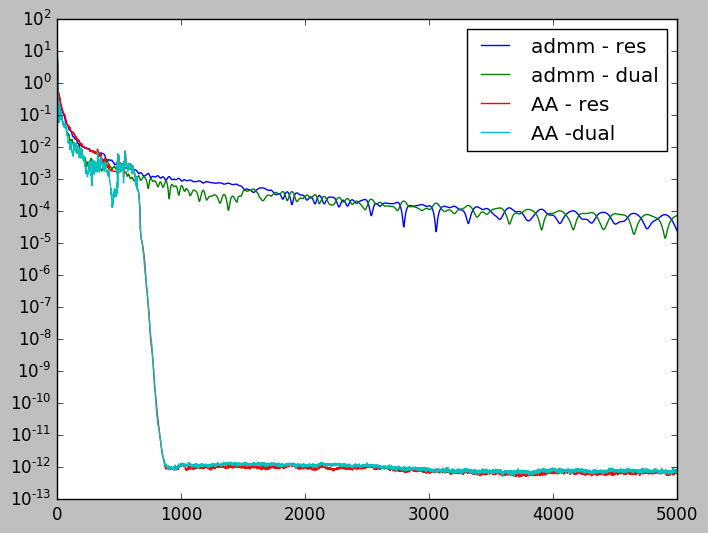

In [17]:
plt.semilogy(r_vanilla, label='admm - res')
plt.semilogy(d_vanilla, label='admm - dual')
plt.semilogy(r_aa, label='AA - res')
plt.semilogy(d_aa, label='AA -dual')
plt.legend()
plt.show()